# Introducción

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

### Inicialización

In [116]:
# Cargar todas las librerías
from scipy import stats as st
import math as mt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

### Cargar datos

In [117]:
# Carga los archivos de datos en diferentes DataFrames
users = pd.read_csv('/datasets/megaline_users.csv')
calls = pd.read_csv('/datasets/megaline_calls.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')


### Preparar los datos

## Tarifas

In [7]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
plans.info()
print(plans.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
0


In [8]:
# Imprime una muestra de los datos para las tarifas
print(plans.head())


   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


<div class="alert alert-block alert-info">

**Macarena :
La tabla de tarifas `plans` contiene toda la información sobre ambos planes (Surf y Ultimate). Sin embargo, hay un problema importante: en la descripción del proyecto se menciona que "para tráfico web, el total del mes se redondea hacia arriba. Si alguien utiliza 1025 megabytes este mes, se le cobrarán 2 gigabytes". Por lo tanto, los megabytes en la columna mb_per_month_included deben ajustarse a 15 y 30 GB, eliminando los megabytes adicionales, para evitar la confusión de que los planes cubren 16 y 31 GB, respectivamente. Además, se añadirá una columna que muestre la misma información en gigabytes.**
   

</div>

### Corregir datos

In [9]:
plans["mb_per_month_included"] = plans["mb_per_month_included"].replace([15360,30720],[15000, 30000])
plans.rename(columns={"plan_name": "plan"}, inplace =True)
print(plans.head())

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15000               500   
1               1000                  30000              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute      plan  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


### Enriquecer los datos

In [10]:
plans['gb_per_month_included'] = plans['mb_per_month_included'] / 1000
print(plans.head())

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15000               500   
1               1000                  30000              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute      plan  \
0               20          10             0.03            0.03      surf   
1               70           7             0.01            0.01  ultimate   

   gb_per_month_included  
0                   15.0  
1                   30.0  


## Usuarios/as

In [11]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
users.info()
print(users.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
0


In [12]:
# Imprime una muestra de datos para usuarios
print(users.head())
print(users["city"].head(20))
print(users["city"].nunique())

   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue, WA MSA   

     reg_date      plan churn_date  
0  2018-12-24  ultimate        NaN  
1  2018-08-13      surf        NaN  
2  2018-10-21      surf        NaN  
3  2018-01-28      surf        NaN  
4  2018-05-23      surf        NaN  
0                Atlanta-Sandy Springs-Roswell, GA MSA
1                      Seattle-Tacoma-Bellevue, WA MSA
2                 Las Vegas-Henderson-Paradise, NV MSA
3                                        Tulsa, OK MSA
4                      Seattle-Tacoma-Bellevue, WA MSA
5                  Dal

<div class="alert alert-block alert-info">

**Macarena :
La tabla `users` presenta información sobre los 500 clientes que conforman la muestra para este proyecto, incluyendo datos como la fecha de inicio de su suscripción, el tipo de tarifa que utilizan, su residencia (ciudad y estado), edad, entre otros.
Un aspecto a señalar es la presencia de datos ausentes en la columna churn_date. Aunque esto podría ser un inconveniente si el análisis requiere datos completos, en este momento no considero necesario reemplazarlos, ya que me indican cuáles usuarios aún cuentan con una suscripción activa. Si en el futuro se requiere un cambio, probablemente se reemplazarán por una fecha ficticia específica (por ejemplo, 1999-01-01) para mantener su distinción.
Además, las columnas churn_date y reg_date contienen valores de fecha, pero actualmente están clasificadas como object. También sugiero que, para futuros análisis, sería conveniente separar la columna city, utilizando la coma como delimitador, para obtener tanto la columna city como la columna state. Por último, se cambiará el tipo de dato de user_id a string para facilitar futuras uniones con otras tablas.**
   
    
</div>

### Corregir los datos

In [13]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['user_id'] = users['user_id'].astype(str)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    object        
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 31.4+ KB


### Enriquecer los datos

In [14]:
users[["city_name", "state"]] = users["city"].str.split(', ', 1, expand=True)
users = users.drop(columns=['city'])
print(users.head())

  user_id first_name  last_name  age   reg_date      plan churn_date  \
0    1000   Anamaria      Bauer   45 2018-12-24  ultimate        NaT   
1    1001     Mickey  Wilkerson   28 2018-08-13      surf        NaT   
2    1002     Carlee    Hoffman   36 2018-10-21      surf        NaT   
3    1003   Reynaldo    Jenkins   52 2018-01-28      surf        NaT   
4    1004    Leonila   Thompson   40 2018-05-23      surf        NaT   

                       city_name   state  
0  Atlanta-Sandy Springs-Roswell  GA MSA  
1        Seattle-Tacoma-Bellevue  WA MSA  
2   Las Vegas-Henderson-Paradise  NV MSA  
3                          Tulsa  OK MSA  
4        Seattle-Tacoma-Bellevue  WA MSA  


## Llamadas

In [15]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [12]:
# Imprime una muestra de datos para las llamadas
print(calls.head(30))
print(calls.duplicated().sum())


          id  user_id   call_date  duration
0    1000_93     1000  2018-12-27      8.52
1   1000_145     1000  2018-12-27     13.66
2   1000_247     1000  2018-12-27     14.48
3   1000_309     1000  2018-12-28      5.76
4   1000_380     1000  2018-12-30      4.22
5   1000_388     1000  2018-12-31      2.20
6   1000_510     1000  2018-12-27      5.75
7   1000_521     1000  2018-12-28     14.18
8   1000_530     1000  2018-12-28      5.77
9   1000_544     1000  2018-12-26      4.40
10  1000_693     1000  2018-12-31      4.31
11  1000_705     1000  2018-12-31     12.78
12  1000_735     1000  2018-12-29      1.70
13  1000_778     1000  2018-12-28      3.29
14  1000_826     1000  2018-12-26      9.96
15  1000_842     1000  2018-12-27      5.85
16    1001_0     1001  2018-09-06     10.06
17    1001_1     1001  2018-10-12      1.00
18    1001_2     1001  2018-10-17     15.83
19    1001_4     1001  2018-12-05      0.00
20    1001_5     1001  2018-12-13      6.27
21    1001_6     1001  2018-12-0

<div class="alert alert-block alert-info">

**Macarena :
La tabla `calls` contiene información sobre todas las llamadas realizadas por la muestra de clientes de Megaline durante el periodo analizado (2018), incluyendo el usuario que realizó la llamada, la fecha y la duración.
Respecto a esta tabla, tengo las siguientes observaciones: primero, el tipo de dato de call_date debería clasificarse como un valor de fecha. En segundo lugar, la columna duration debe redondearse hacia arriba, conforme a lo indicado en la descripción del proyecto: "Nota: Megaline redondea los segundos a minutos y los megabytes a gigabytes. Para llamadas, cada llamada individual se redondea; incluso si la llamada duró solo un segundo, se contará como un minuto".
Por último, sería útil enriquecer la tabla añadiendo una columna que indique únicamente el mes. Dado que estamos midiendo tarifas que consideran el gasto mensual de cada usuario para calcular los cobros, esta columna facilitaría el agrupamiento del consumo por usuario.**
   
    
</div>

### Corregir los datos

In [16]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['duration'] = np.ceil(calls['duration']).astype('int64')

print(calls.head())
print()
calls.info()

         id  user_id  call_date  duration
0   1000_93     1000 2018-12-27         9
1  1000_145     1000 2018-12-27        14
2  1000_247     1000 2018-12-27        15
3  1000_309     1000 2018-12-28         6
4  1000_380     1000 2018-12-30         5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.2+ MB


### Enriquecer los datos

In [17]:
calls['month'] = calls['call_date'].dt.month

print(calls.head())
print()
calls.info()

         id  user_id  call_date  duration  month
0   1000_93     1000 2018-12-27         9     12
1  1000_145     1000 2018-12-27        14     12
2  1000_247     1000 2018-12-27        15     12
3  1000_309     1000 2018-12-28         6     12
4  1000_380     1000 2018-12-30         5     12

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
 4   month      137735 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 5.3+ MB


## Mensajes

In [18]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
messages.info()
print(messages.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
0


In [19]:
# Imprime una muestra de datos para los mensajes
print(messages.head())


         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26


<div class="alert alert-block alert-info">

**Macarena :
La tabla de `messages` contiene información sobre todos los mensajes enviados por la muestra de clientes de Megaline durante el periodo analizado (2018), incluyendo el usuario que los envió y la fecha de envío.
Respecto a esta tabla, tengo las siguientes observaciones: en primer lugar, el tipo de dato de message_date debería clasificarse como un valor de fecha. Además, sería útil enriquecer la tabla añadiendo una columna que indique únicamente el mes. Dado que estamos midiendo tarifas que consideran el gasto mensual de cada usuario para calcular los cobros, esta columna facilitaría el agrupamiento del consumo por usuario.**
   
    
</div>

### Corregir los datos

In [20]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

print(messages.head())
print()
messages.info()

         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


### Enriquecer los datos

In [21]:
messages['month'] = messages['message_date'].dt.month

print(messages.head())
print()
messages.info()

         id  user_id message_date  month
0  1000_125     1000   2018-12-27     12
1  1000_160     1000   2018-12-31     12
2  1000_223     1000   2018-12-31     12
3  1000_251     1000   2018-12-27     12
4  1000_255     1000   2018-12-26     12

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.3+ MB


## Internet

In [22]:
# Imprime la información general/resumida sobre el DataFrame de internet
internet.info()
print(internet.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
0


In [23]:
# Imprime una muestra de datos para el tráfico de internet
print(internet.head())


         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22




<div class="alert alert-block alert-info">

**Macarena :
La tabla `internet` contiene información sobre el tráfico de datos utilizado por la muestra de clientes de Megaline durante el periodo analizado (2018), indicando el usuario que realizó cada sesión, la fecha de la sesión y los megabytes utilizados.
Respecto a esta tabla, tengo las siguientes observaciones: en primer lugar, el tipo de dato de session_date debería clasificarse como un valor de fecha. Además, sería beneficioso enriquecer la tabla añadiendo una columna que indique únicamente el mes. Dado que estamos midiendo tarifas que consideran el gasto mensual de cada usuario para calcular los cobros, esta columna facilitaría el agrupamiento del consumo por usuario.**
   
    
</div>

### Corregir los datos

In [24]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

print(internet.head())
print()
internet.info()

         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


### Enriquecer los datos

In [25]:
internet['month'] = internet['session_date'].dt.month
print(internet.head())
print()
internet.info()

         id  user_id session_date  mb_used  month
0   1000_13     1000   2018-12-29    89.86     12
1  1000_204     1000   2018-12-31     0.00     12
2  1000_379     1000   2018-12-28   660.40     12
3  1000_413     1000   2018-12-26   270.99     12
4  1000_442     1000   2018-12-27   880.22     12

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   month         104825 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 4.0+ MB


## Estudiar las condiciones de las tarifas

In [26]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
plans.info()
print(plans.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan                   2 non-null      object 
 8   gb_per_month_included  2 non-null      float64
dtypes: float64(3), int64(5), object(1)
memory usage: 272.0+ bytes
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15000               500   
1               1000                  30000              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute  

## Agregar datos por usuario



In [27]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
print(calls)

calls_grp = calls.groupby(['user_id', 'month']).agg(number_of_calls =('id', 'count'), duration_calls =('duration','sum')).reset_index().sort_values(by="user_id", ascending=False)
print(calls_grp.head())
calls_grp.info()
calls_grp['user_month'] = calls_grp['user_id'].astype(str) + '_' + calls_grp['month'].astype(str)
print()
print(calls_grp.head(25))
calls_grp.info()




              id  user_id  call_date  duration  month
0        1000_93     1000 2018-12-27         9     12
1       1000_145     1000 2018-12-27        14     12
2       1000_247     1000 2018-12-27        15     12
3       1000_309     1000 2018-12-28         6     12
4       1000_380     1000 2018-12-30         5     12
...          ...      ...        ...       ...    ...
137730  1499_199     1499 2018-11-21         9     11
137731  1499_200     1499 2018-10-20        11     10
137732  1499_201     1499 2018-09-21         9      9
137733  1499_202     1499 2018-10-10         1     10
137734  1499_203     1499 2018-12-29        14     12

[137735 rows x 5 columns]
      user_id  month  number_of_calls  duration_calls
2257     1499     12               65             496
2256     1499     11               45             308
2255     1499     10               53             385
2254     1499      9               41             346
2243     1498      2               37             244
<

<div class="alert alert-block alert-info">

**Macarena :
Se genera una nueva tabla agrupada por usuario y mes, de manera que haya un único registro por usuario y periodo. En esta tabla, se incluye la cantidad de llamadas y la duración total de cada registro. Además, se crea una columna que fusiona el usuario y el mes, llamada user_month, que se utilizará como llave primaria para las funciones que se presentarán más adelante.**
   
    
</div>

In [29]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.

print(messages.head())
messages_grp = messages.groupby(['user_id', 'month']).agg(total_messages=('id', 'count')).reset_index().sort_values(by="user_id", ascending=False)
messages_grp.info()
messages_grp['user_month'] = messages_grp['user_id'].astype(str) + '_' + messages_grp['month'].astype(str)
print(messages_grp.head(25))
messages_grp.info()




         id  user_id message_date  month
0  1000_125     1000   2018-12-27     12
1  1000_160     1000   2018-12-31     12
2  1000_223     1000   2018-12-31     12
3  1000_251     1000   2018-12-27     12
4  1000_255     1000   2018-12-26     12
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1806 entries, 1805 to 0
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   user_id         1806 non-null   int64
 1   month           1806 non-null   int64
 2   total_messages  1806 non-null   int64
dtypes: int64(3)
memory usage: 56.4 KB
      user_id  month  total_messages user_month
1805     1497     12              50    1497_12
1804     1496     12              11    1496_12
1803     1496     11              13    1496_11
1802     1496     10              18    1496_10
1801     1496      9              21     1496_9
1800     1496      8               2     1496_8
1799     1494     12              33    1494_12
1798     1

<div class="alert alert-block alert-info">

**Macarena :
Se crea una nueva tabla agrupada por usuario y mes, asegurando que haya un único registro por usuario y periodo. En esta tabla, se incluye la cantidad de mensajes de cada registro y se genera también la columna user_month.**
   
    
</div>

In [30]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
print(internet.head())
internet_grp = internet.groupby(['user_id', 'month']).agg(total_data_mb=('mb_used', 'sum')).reset_index().sort_values(by="user_id", ascending=False)
print()
internet_grp.info()
internet_grp['user_month'] = internet_grp['user_id'].astype(str) + '_' + internet_grp['month'].astype(str)
print()
print(internet_grp.head(25))
internet_grp.info()


         id  user_id session_date  mb_used  month
0   1000_13     1000   2018-12-29    89.86     12
1  1000_204     1000   2018-12-31     0.00     12
2  1000_379     1000   2018-12-28   660.40     12
3  1000_413     1000   2018-12-26   270.99     12
4  1000_442     1000   2018-12-27   880.22     12

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2277 entries, 2276 to 0
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        2277 non-null   int64  
 1   month          2277 non-null   int64  
 2   total_data_mb  2277 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 71.2 KB

      user_id  month  total_data_mb user_month
2276     1499     12       22059.21    1499_12
2275     1499     11       16813.83    1499_11
2274     1499     10       19492.43    1499_10
2273     1499      9       12984.76     1499_9
2262     1498      2       19822.04     1498_2
2272     1498     12       23137.69    

<div class="alert alert-block alert-info">

**Macarena :
Se crea una nueva tabla agrupada por usuario y mes, asegurando que haya un único registro por usuario y periodo. En esta tabla, se incluye la cantidad de tráfico de internet de cada registro y se genera también la columna user_month.**
   
    
</div>

In [31]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
grp = calls_grp.merge(messages_grp, on='user_month', how='outer')
grp = grp.drop(["user_id_x",'month_x',"user_id_y",'month_y'], axis="columns")
grp = grp.merge(internet_grp, on='user_month', how='outer')
grp = grp.drop(["user_id",'month'], axis="columns")
grp[["user_id", "month"]] = grp["user_month"].str.split('_', 1, expand=True)
grp = grp.drop(columns=['user_month'])
print(grp)
grp.info()
grp['total_data_gb'] = grp['total_data_mb'] / 1000
grp['total_data_gb'] = np.ceil(grp['total_data_gb'])
print(grp)


      number_of_calls  duration_calls  total_messages  total_data_mb user_id  \
0                65.0           496.0             NaN       22059.21    1499   
1                45.0           308.0             NaN       16813.83    1499   
2                53.0           385.0             NaN       19492.43    1499   
3                41.0           346.0             NaN       12984.76    1499   
4                37.0           244.0             NaN       19822.04    1498   
...               ...             ...             ...            ...     ...   
2288              NaN             NaN            50.0       33559.88    1080   
2289              NaN             NaN            61.0       24543.42    1080   
2290              NaN             NaN            12.0       12591.91    1028   
2291              NaN             NaN             NaN        1498.83    1311   
2292              NaN             NaN             NaN         233.17    1108   

     month  
0       12  
1       11  



<div class="alert alert-block alert-info">

**Macarena :
    Se crea una nueva tabla `grp` que reúne todo el consumo de cada usuario por mes, obtenida al fusionar las tablas agrupadas generadas en el paso anterior mediante la columna user_month. Además, se separa la columna user_month en sus dos componentes originales y se agrega una columna que muestra el tráfico de internet consumido en gigabytes, redondeado hacia arriba. Esto se realiza porque, como se indicó en la descripción del proyecto, el valor se redondea únicamente cuando se considera el consumo total del mes por el usuario.**
   
    
</div>

In [78]:
# Añade la información de la tarifa
user = users[['user_id', 'plan','state']]
final_grp = grp.merge(user, on='user_id', how='left')

final_grp =final_grp.merge(plans, on='plan')
final_grp['month'] = final_grp['month'].astype(int)
print()
print(final_grp)
final_grp.info()


      number_of_calls  duration_calls  total_messages  total_data_mb user_id  \
0                65.0           496.0             NaN       22059.21    1499   
1                45.0           308.0             NaN       16813.83    1499   
2                53.0           385.0             NaN       19492.43    1499   
3                41.0           346.0             NaN       12984.76    1499   
4                37.0           244.0             NaN       19822.04    1498   
...               ...             ...             ...            ...     ...   
2288              NaN             NaN            78.0       36730.05    1204   
2289              NaN             NaN            42.0       21346.95    1204   
2290              NaN             NaN            12.0       12591.91    1028   
2291              NaN             NaN             NaN        1498.83    1311   
2292              NaN             NaN             NaN         233.17    1108   

      month  total_data_gb      plan  


<div class="alert alert-block alert-info">

**Macarena :
A la tabla generada anteriormente se le fusiona con una tabla resumen de `users` para obtener la tarifa asociada a cada cliente. Con esta información, se realiza un segundo merge para añadir las columnas de la tabla `plans`, lo que permitirá realizar análisis adicionales en el futuro.**
   
    
</div>

In [79]:
# Calcula el ingreso mensual para cada usuario
final_grp['extra_usd_per_call'] = np.where(final_grp['duration_calls'] > final_grp['minutes_included'],
                                 final_grp['duration_calls'] - final_grp['minutes_included'],
                                 0).astype('int64')
final_grp['extra_usd_per_call'] = final_grp['extra_usd_per_call'] * final_grp['usd_per_minute']

final_grp['extra_usd_per_msg'] = np.where(final_grp['total_messages'] > final_grp['messages_included'],
                                 final_grp['total_messages'] - final_grp['messages_included'],
                                 0).astype('int64')
final_grp['extra_usd_per_msg'] = final_grp['extra_usd_per_msg'] * final_grp['usd_per_message']

final_grp['extra_usd_per_gb'] = np.where(final_grp['total_data_gb'] > final_grp['gb_per_month_included'],
                                 final_grp['total_data_gb'] - final_grp['gb_per_month_included'],
                                 0).astype('int64')
final_grp['extra_usd_per_gb'] = final_grp['extra_usd_per_gb'] * final_grp['usd_per_gb']

final_grp['final_payment'] = final_grp['usd_monthly_pay'] + final_grp['extra_usd_per_call'] + final_grp['extra_usd_per_msg'] + final_grp['extra_usd_per_gb'] 
print(final_grp.head())
final_grp.info()


   number_of_calls  duration_calls  total_messages  total_data_mb user_id  \
0             65.0           496.0             NaN       22059.21    1499   
1             45.0           308.0             NaN       16813.83    1499   
2             53.0           385.0             NaN       19492.43    1499   
3             41.0           346.0             NaN       12984.76    1499   
4             37.0           244.0             NaN       19822.04    1498   

   month  total_data_gb  plan         state  messages_included  ...  \
0     12           23.0  surf        FL MSA                 50  ...   
1     11           17.0  surf        FL MSA                 50  ...   
2     10           20.0  surf        FL MSA                 50  ...   
3      9           13.0  surf        FL MSA                 50  ...   
4      2           20.0  surf  NY-NJ-PA MSA                 50  ...   

   minutes_included  usd_monthly_pay  usd_per_gb  usd_per_message  \
0               500               20     




<div class="alert alert-block alert-info">

**Macarena :
Se generan tres nuevas columnas que muestran la cantidad adicional que debe pagar cada usuario en un mes determinado si ha excedido los minutos, la cantidad de mensajes o los gigabytes incluidos en el plan al que están asociados. Finalmente, se crea una última columna llamada final_payment, que contendrá una suma de todos estos posibles cargos extras, además del valor de la tarifa que contrataron.**
   
    
</div>

## Estudia el comportamiento de usuario

In [80]:
plan_surf = final_grp[final_grp["plan"] == 'surf']
plan_ultimate = final_grp[final_grp["plan"] == 'ultimate']

print(plan_surf.groupby("month")["user_id"].count())
print(plan_ultimate.groupby("month")["user_id"].count())


month
1       2
2       9
3      23
4      50
5      77
6      97
7     121
8     162
9     194
10    237
11    283
12    318
Name: user_id, dtype: int64
month
1       4
2       7
3      12
4      21
5      29
6      47
7      59
8      71
9      86
10    106
11    127
12    151
Name: user_id, dtype: int64


<div class="alert alert-block alert-info">

**Macarena :
Antes de analizar el comportamiento de los usuarios en relación con llamadas, mensajes e internet, se revisa la muestra real de clientes por mes en cada plan. Se observa que ambos planes experimentan un crecimiento mensual en la cantidad de clientes. Sin embargo, el plan Surf muestra un crecimiento mucho más exponencial en comparación con el plan Ultimate, alcanzando más del doble de clientes contratados en el último mes medido (diciembre de 2018).**

    
</div>

### Llamadas

month
1     203.000000
2     297.000000
3     330.000000
4     351.540000
5     410.240000
6     435.791667
7     453.733333
8     417.849057
9     420.732984
10    438.991379
11    432.494585
12    484.501608
Name: duration_calls, dtype: float64
month
1     193.500000
2     470.333333
3     304.250000
4     336.857143
5     406.241379
6     387.444444
7     427.067797
8     421.436620
9     437.511628
10    455.028571
11    448.730159
12    465.261745
Name: duration_calls, dtype: float64


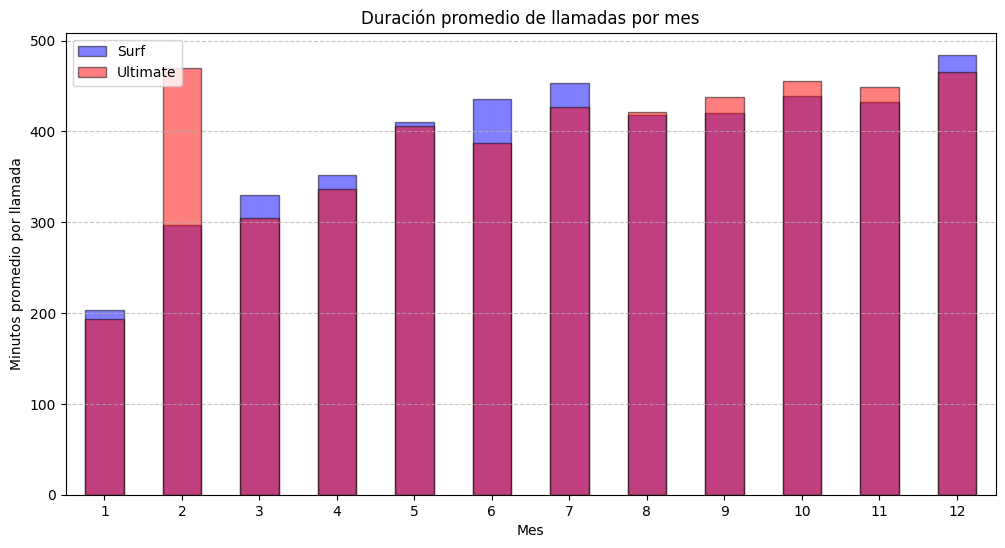

In [81]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.

print(plan_surf.groupby("month")["duration_calls"].mean())
print(plan_ultimate.groupby("month")["duration_calls"].mean())


plan_surf.groupby("month")["duration_calls"].mean().plot(kind="bar",
        xlabel='Mes',
        ylabel='Minutos promedio por llamada',
        rot=360,
        figsize=(12, 6),
        color='blue', 
        edgecolor='black',  alpha=0.5
                                                                 
)


plan_ultimate.groupby("month")["duration_calls"].mean().plot(kind="bar",
        xlabel='Mes',
        ylabel='Minutos promedio por llamada',
        rot=360,
        figsize=(12, 6),
        color='red', 
        edgecolor='black', alpha=0.5
                                                                 
)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title("Duración promedio de llamadas por mes")
plt.legend(["Surf", "Ultimate"])
plt.show()



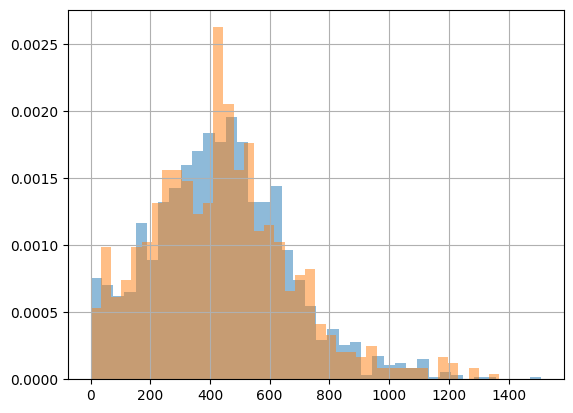

In [82]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
plan_surf['duration_calls'].hist(bins=40, alpha=0.5, density=True)
plan_ultimate['duration_calls'].hist(bins=40, alpha=0.5, density=True)
plt.show()

[Calcula la media y la variable de la duración de las llamadas para averiguar si los usuarios de los distintos planes se comportan de forma diferente al realizar sus llamadas.]

In [83]:
# Calcula la media y la varianza de la duración mensual de llamadas.
print('media muestral:',final_grp['duration_calls'].mean())
print('varianza muestral:',final_grp['duration_calls'].var())
print()
print('media muestral plan surf:',plan_surf['duration_calls'].mean())
print('varianza muestral plan surf:',plan_surf['duration_calls'].var())
print()
print('media muestral plan ultimate:',plan_ultimate['duration_calls'].mean())
print('varianza muestral plan ultimate:',plan_ultimate['duration_calls'].var())

media muestral: 435.9375553587245
varianza muestral: 53811.16800855365

media muestral plan surf: 436.51974110032364
varianza muestral plan surf: 52571.06324345624

media muestral plan ultimate: 434.67601683029454
varianza muestral plan ultimate: 56573.63224703343


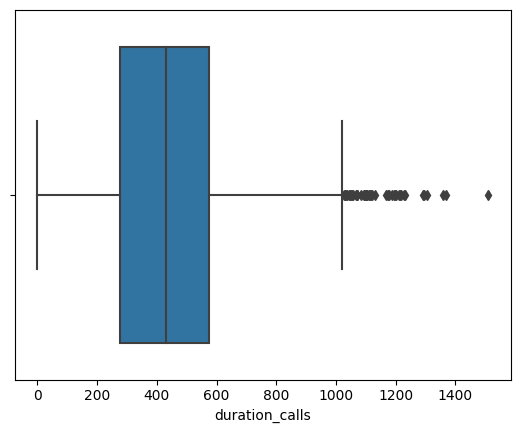

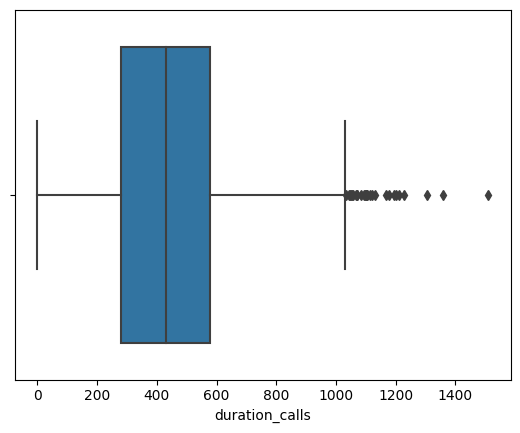

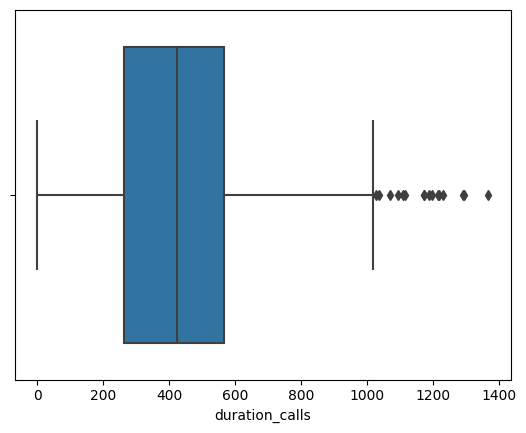

In [84]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
sns.boxplot(final_grp['duration_calls'])
plt.show()
sns.boxplot(plan_surf['duration_calls'])
plt.show()
sns.boxplot(plan_ultimate['duration_calls'])
plt.show()




<div class="alert alert-block alert-info">

**Macarena :
Después de analizar el comportamiento de ambos planes en función de la duración total de las llamadas mensuales mediante histogramas de densidad, gráficos de barras que representan los promedios, diagramas de cajas y comparaciones de media y varianza, se concluye que no hay diferencias significativas en el promedio, la dispersión y la varianza de la duración de las llamadas entre los dos planes. La mayoría de los clientes, independientemente del plan, tienden a utilizar entre 300 y 600 minutos aproximadamente. Por lo tanto, podría considerarse que el plan Surf es más conveniente, ya que por una tarifa de 20 dólares incluye 500 minutos. Además, si se supera esta cantidad, el costo adicional es de solo 3 centavos por minuto, lo que significaría que alcanzar los 600 minutos solo implicaría un gasto extra de 3 dólares.**

    
</div>

### Mensajes

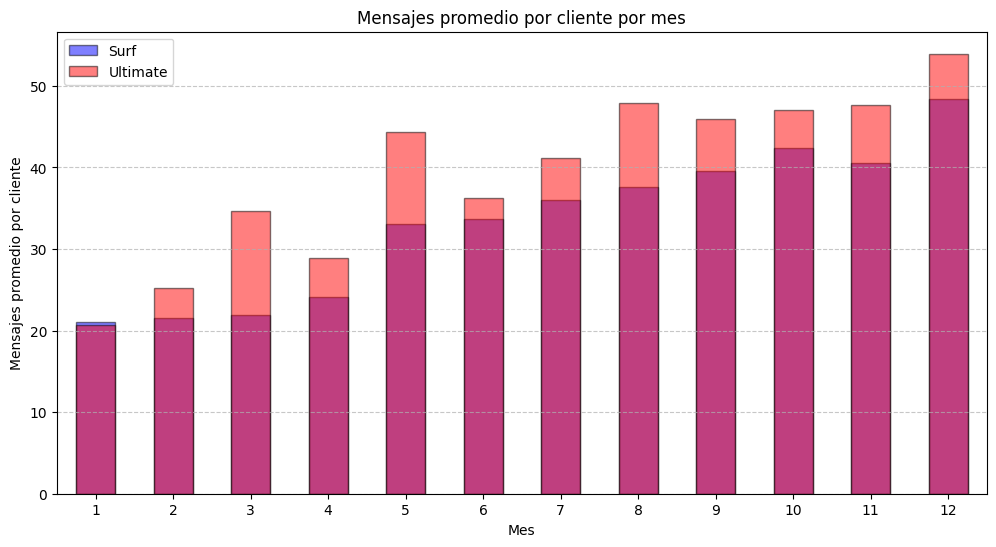

In [85]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
plan_surf.groupby("month")["total_messages"].mean().plot(kind="bar",
        xlabel='Mes',
        ylabel='Mensajes promedio por cliente',
        rot=360,
        figsize=(12, 6),
        color='blue', 
        edgecolor='black',  alpha=0.5
                                                                 
)


plan_ultimate.groupby("month")["total_messages"].mean().plot(kind="bar",
        xlabel='Mes',
        ylabel='Mensajes promedio por cliente',
        rot=360,
        figsize=(12, 6),
        color='red', 
        edgecolor='black', alpha=0.5
                                                                 
)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title("Mensajes promedio por cliente por mes")
plt.legend(["Surf", "Ultimate"])
plt.show()



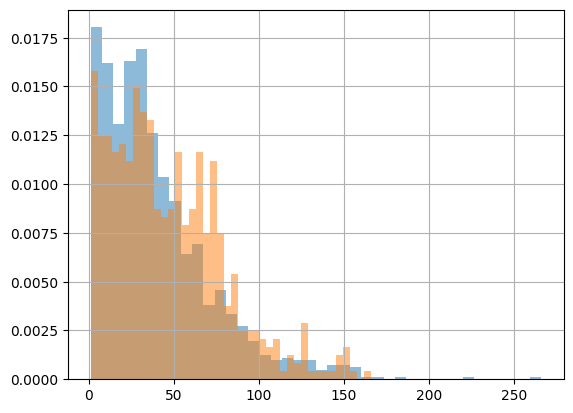

In [86]:
plan_surf['total_messages'].hist(bins=40, alpha=0.5, density=True)
plan_ultimate['total_messages'].hist(bins=40, alpha=0.5, density=True)
plt.show()


media muestral: 42.110188261351055
varianza muestral: 1097.1285720421004

media muestral plan surf: 40.10965630114566
varianza muestral plan surf: 1091.3442310038054

media muestral plan ultimate: 46.29623287671233
varianza muestral plan ultimate: 1085.183107568317


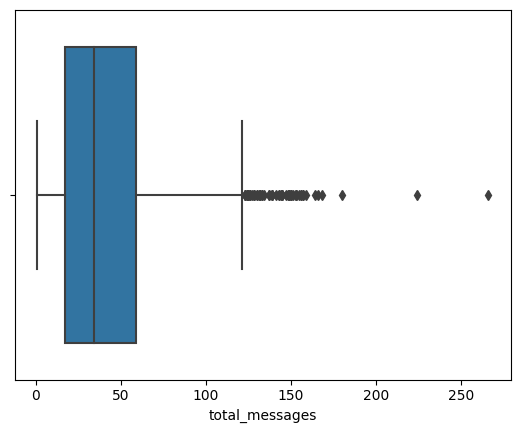

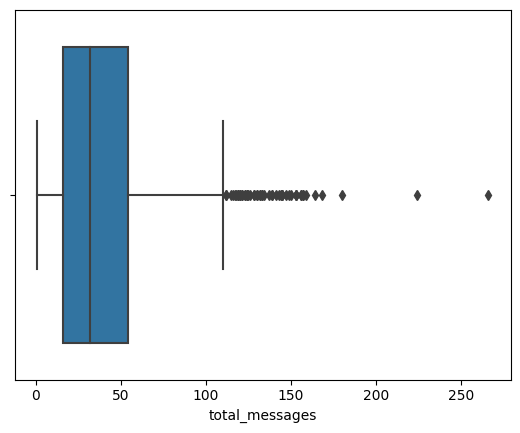

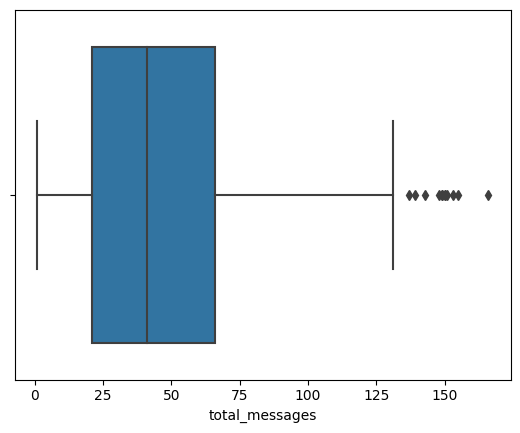

In [87]:
print('media muestral:',final_grp['total_messages'].mean())
print('varianza muestral:',final_grp['total_messages'].var())
print()
print('media muestral plan surf:',plan_surf['total_messages'].mean())
print('varianza muestral plan surf:',plan_surf['total_messages'].var())
print()
print('media muestral plan ultimate:',plan_ultimate['total_messages'].mean())
print('varianza muestral plan ultimate:',plan_ultimate['total_messages'].var())

sns.boxplot(final_grp['total_messages'])
plt.show()
sns.boxplot(plan_surf['total_messages'])
plt.show()
sns.boxplot(plan_ultimate['total_messages'])
plt.show()

<div class="alert alert-block alert-info">

**Macarena : 
Después de analizar el comportamiento de ambos planes en función de la cantidad total de mensajes enviados mensualmente mediante histogramas de densidad, gráficos de barras que representan los promedios, diagramas de cajas y comparaciones de media y varianza, se concluye que, si bien los clientes del plan Ultimate tienden a enviar más mensajes que los del plan Surf, los promedios de ambos se mantienen por debajo de los 50 SMS al mes (excepto en el mes 12), lo cual está dentro de lo cubierto por el plan Surf. Además, en el diagrama de caja del plan Ultimate, se observa que uno de los puntos de corte antes de que comiencen a aparecer valores anormales es aproximadamente la cantidad de 130 mensajes. Esto implica que, desde los 50 mensajes ya incluidos en el plan Surf, solo sería necesario un recargo de 80 centavos para poder enviar mensualmente 130 mensajes.**

    
</div>

### Internet

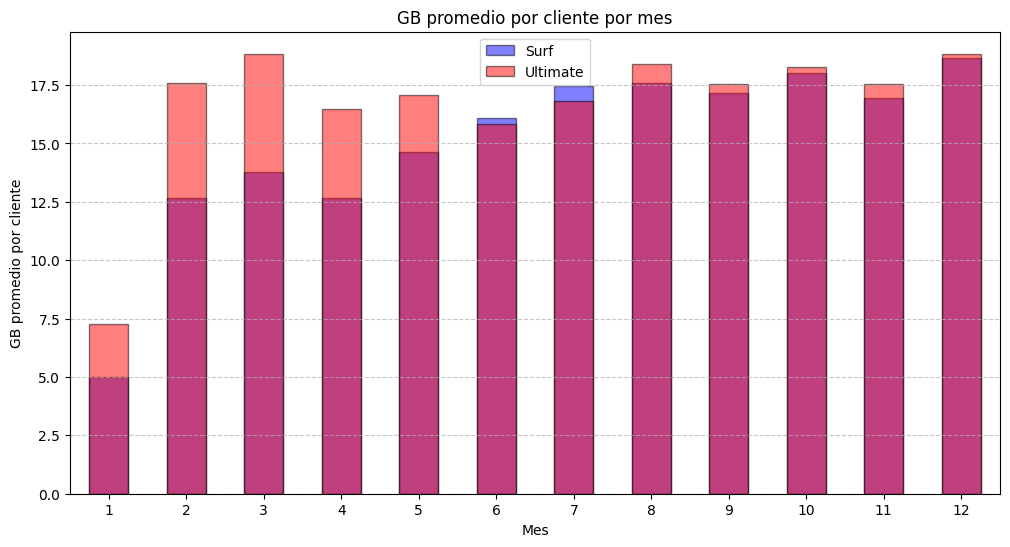

In [88]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
plan_surf.groupby("month")["total_data_gb"].mean().plot(kind="bar",
        xlabel='Mes',
        ylabel='GB promedio por cliente',
        rot=360,
        figsize=(12, 6),
        color='blue', 
        edgecolor='black',  alpha=0.5
                                                                 
)


plan_ultimate.groupby("month")["total_data_gb"].mean().plot(kind="bar",
        xlabel='Mes',
        ylabel='GB promedio por cliente',
        rot=360,
        figsize=(12, 6),
        color='red', 
        edgecolor='black', alpha=0.5
                                                                 
)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title("GB promedio por cliente por mes")
plt.legend(["Surf", "Ultimate"])
plt.show()


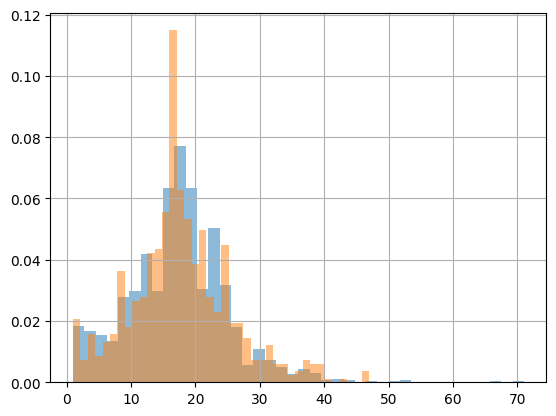

In [89]:
plan_surf['total_data_gb'].hist(bins=40, alpha=0.5, density=True)
plan_ultimate['total_data_gb'].hist(bins=40, alpha=0.5, density=True)
plt.show()


media muestral: 17.372859025032938
varianza muestral: 61.92198712115424

media muestral plan surf: 17.201540436456995
varianza muestral plan surf: 62.05826352148524

media muestral plan ultimate: 17.744089012517385
varianza muestral plan ultimate: 61.511020025491916


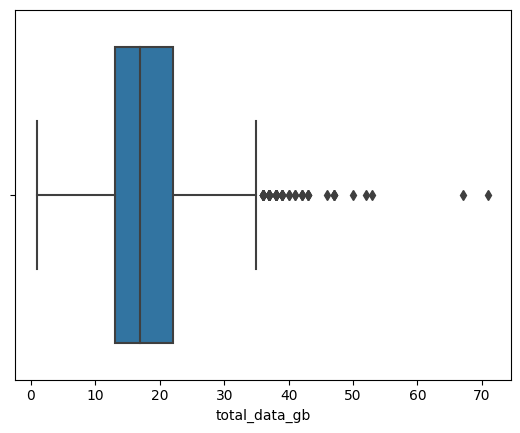

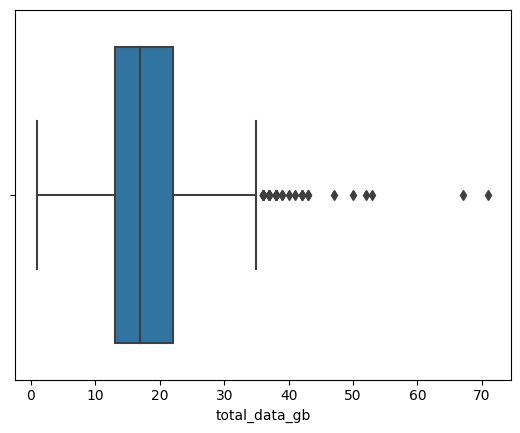

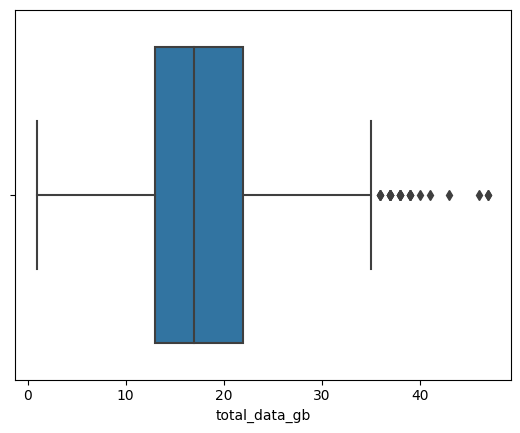

In [90]:
print('media muestral:',final_grp['total_data_gb'].mean())
print('varianza muestral:',final_grp['total_data_gb'].var())
print()
print('media muestral plan surf:',plan_surf['total_data_gb'].mean())
print('varianza muestral plan surf:',plan_surf['total_data_gb'].var())
print()
print('media muestral plan ultimate:',plan_ultimate['total_data_gb'].mean())
print('varianza muestral plan ultimate:',plan_ultimate['total_data_gb'].var())

sns.boxplot(final_grp['total_data_gb'])
plt.show()
sns.boxplot(plan_surf['total_data_gb'])
plt.show()
sns.boxplot(plan_ultimate['total_data_gb'])
plt.show()

<div class="alert alert-block alert-info">

**Macarena : 
Después de analizar el comportamiento de ambos planes en función de la cantidad de tráfico de internet utilizado mensualmente mediante histogramas de densidad, gráficos de barras que representan los promedios, diagramas de cajas y comparaciones de media y varianza, se concluye que, si bien los clientes del plan Ultimate tienden a utilizar más gigabytes que los del plan Surf, los promedios de ambos se sitúan por encima de lo incluido en el plan Surf, que ofrece solo 15 gigabytes. Además, considerando los precios de ambas tarifas y sus recargos, sabemos que, si un cliente del plan Surf utiliza más de 20 gigabytes, le resultaría más conveniente contratar el plan Ultimate. Según esta información, en los diagramas de cajas de ambos planes se observa que el rango intercuartílico (IQR) incluye cantidades de 20 gigabytes o más, y el valor máximo de ambos se aproxima a 35 gigabytes. Esto implica que varios clientes con el plan Surf, independientemente de cómo utilicen sus minutos y mensajes incluidos, se verían más beneficiados al cambiar de plan debido a la cantidad de internet que consumen mensualmente.**

    
</div>

### Ingreso

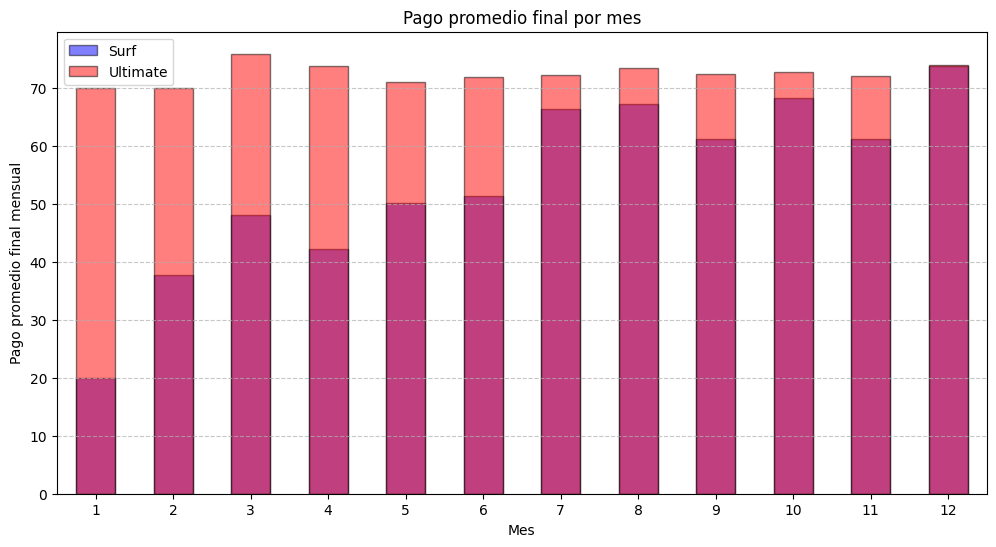

In [91]:
plan_surf.groupby("month")["final_payment"].mean().plot(kind="bar",
        xlabel='Mes',
        ylabel='Pago promedio final mensual',
        rot=360,
        figsize=(12, 6),
        color='blue', 
        edgecolor='black',  alpha=0.5
                                                                 
)


plan_ultimate.groupby("month")["final_payment"].mean().plot(kind="bar",
        xlabel='Mes',
        ylabel='Pago promedio final mensual',
        rot=360,
        figsize=(12, 6),
        color='red', 
        edgecolor='black', alpha=0.5
                                                                 
)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Pago promedio final por mes')
plt.legend(["Surf", "Ultimate"])
plt.show()

In [119]:
print(plan_surf.groupby("month")["final_payment"].mean())
print(plan_ultimate.groupby("month")["final_payment"].mean())
print(plan_surf.groupby("month")["final_payment"].median())
print(plan_ultimate.groupby("month")["final_payment"].median())


month
1     20.000000
2     37.730000
3     48.115217
4     42.110600
5     50.095714
6     51.338144
7     66.227769
8     67.141049
9     61.106546
10    68.163840
11    61.149152
12    73.670252
Name: final_payment, dtype: float64
month
1     70.000000
2     70.000000
3     75.833333
4     73.666667
5     70.965517
6     71.787234
7     72.135593
8     73.450704
9     72.360465
10    72.641509
11    71.984252
12    73.847682
Name: final_payment, dtype: float64
month
1     20.000
2     29.570
3     20.000
4     20.000
5     21.800
6     31.100
7     43.800
8     45.880
9     45.520
10    50.090
11    42.520
12    54.185
Name: final_payment, dtype: float64
month
1     70.0
2     70.0
3     70.0
4     70.0
5     70.0
6     70.0
7     70.0
8     70.0
9     70.0
10    70.0
11    70.0
12    70.0
Name: final_payment, dtype: float64


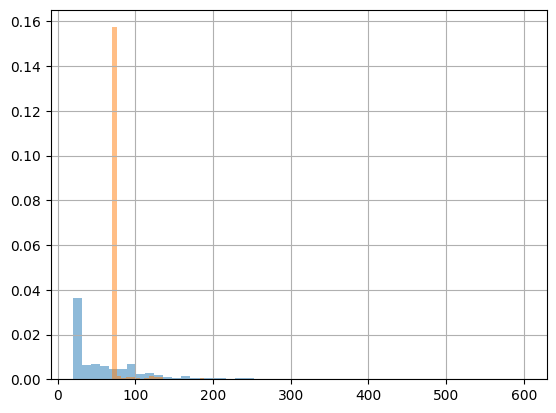

In [114]:
plan_surf["final_payment"].hist(bins=50, alpha=0.5, density=True)
plan_ultimate["final_payment"].hist(bins=20, alpha=0.5, density=True)
plt.show()

media muestral: 66.4662799825556
varianza muestral: 2328.5242184852755

media muestral plan surf: 63.6116846789574
media muestral plan surf: 43.81
varianza muestral plan surf: 3295.59769417023

media muestral plan ultimate: 72.70277777777778
media muestral plan ultimate: 70.0
varianza muestral plan ultimate: 160.6069463761397


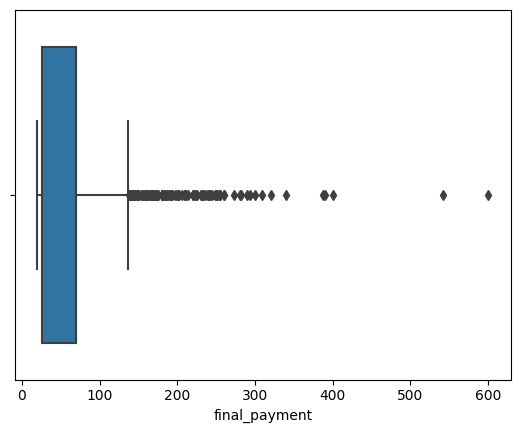

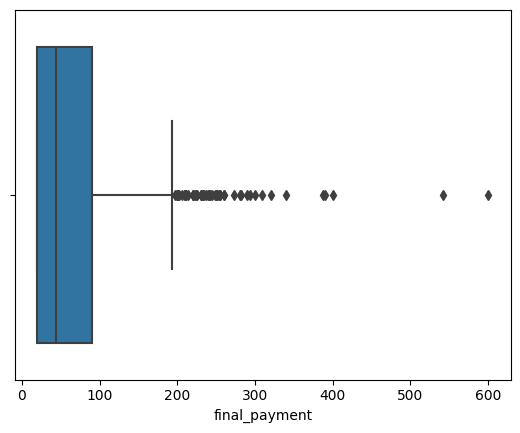

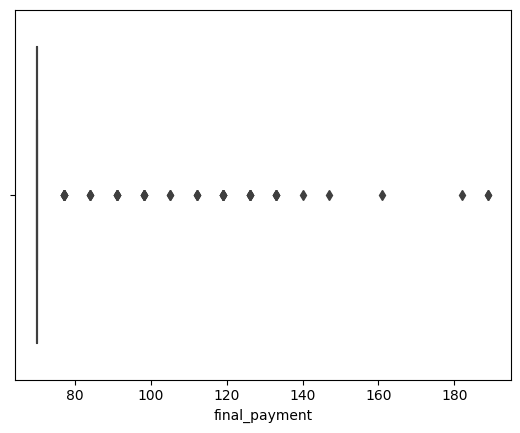

In [115]:
print('media muestral:',final_grp['final_payment'].mean())
print('varianza muestral:',final_grp['final_payment'].var())
print()
print('media muestral plan surf:',plan_surf['final_payment'].mean())
print('media muestral plan surf:',plan_surf['final_payment'].median())
print('varianza muestral plan surf:',plan_surf['final_payment'].var())
print()
print('media muestral plan ultimate:',plan_ultimate['final_payment'].mean())
print('media muestral plan ultimate:',plan_ultimate['final_payment'].median())
print('varianza muestral plan ultimate:',plan_ultimate['final_payment'].var())

sns.boxplot(final_grp['final_payment'])
plt.show()
sns.boxplot(plan_surf['final_payment'])
plt.show()
sns.boxplot(plan_ultimate['final_payment'])
plt.show()

<div class="alert alert-block alert-info">

**Macarena : 
Después de analizar el comportamiento de ambos planes en función del monto final mensual que pagan los clientes, utilizando histogramas de densidad, gráficos de barras para representar los promedios, diagramas de cajas y comparaciones de media, mediana y varianza, se concluye que los clientes afiliados al plan Ultimate exhiben un comportamiento bastante estático, con baja varianza. Los casos en los que pagan un recargo por encima del valor del plan son mínimos y, en su mayoría, se clasifican como valores atípicos. En contraste, aunque los clientes del plan Surf presentan una media más baja, muestran una mayor dispersión en sus pagos. Esto se debe a que, al no incluir un alto volumen de tráfico de internet y tener un servicio con recargos elevados, el pago final de estos clientes tiende a ser más diverso, en ocasiones superando el monto del plan Ultimate.**

    
</div>

## Prueba las hipótesis estadísticas

In [95]:
# Prueba las hipótesis 
#hipotesis nula: los ingresos promedios de ambos planes son iguales
#hipotesis alternativa: los ingresos promedios de ambos planes son diferentes
surf_payment = plan_surf['final_payment']
ultimate_payment = plan_ultimate['final_payment']

alpha = 0.05  # el nivel de significancia estadística crítica
# si el valor p es menor que alpha, rechazamos la hipótesis

results = st.ttest_ind(surf_payment, ultimate_payment, equal_var = False)

print('valor p:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")


valor p: 2.81373182813939e-09
Rechazamos la hipótesis nula


<div class="alert alert-block alert-info">

**Macarena : 
Se realiza una prueba t para las medias de dos muestras independientes con el objetivo de determinar si los ingresos promedio de los usuarios de los planes Surf y Ultimate son diferentes (hipótesis alternativa). En este caso, se puede rechazar la hipótesis nula porque el valor p es significativamente menor que el nivel de significancia establecido (5%). Esto indica que hay una evidencia estadística sólida que sugiere que los ingresos promedios de los usuarios de ambos planes son diferentes. La diferencia en los ingresos es lo suficientemente grande como para que no sea atribuible al azar.**

</div>



Para la segunda hipotesis se toma como supuesto que la instrución inicial hacia referencía a la única área que se componia tando de NY como de NJ.

In [113]:
# Prueba las hipótesis
#hipotesis nula: los ingresos promedios de los usuarios del área de NY-NJ iguales al de usuarios de otras áreas
#hipotesis alternativa: los ingresos promedios de los usuarios del área de NY-NJ son diferentes al de otros usuarios
ny_nj = final_grp[final_grp["state"] == 'NY-NJ-PA MSA']
other_state = final_grp[final_grp["state"] != 'NY-NJ-PA MSA']

ny_nj_payment = ny_nj['final_payment']
other_state_payment = other_state['final_payment']
alpha = 0.05


results_ny = st.ttest_ind(ny_nj_payment, other_state_payment, equal_var = False)

print('valor p:', results_ny.pvalue)

if results_ny.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")


valor p: 0.08381531697981823
No podemos rechazar la hipótesis nula


<div class="alert alert-block alert-info">

**Macarena : 
En este análisis, no se puede rechazar la hipótesis nula debido a que el valor p obtenido (8%) es mayor que el nivel de significancia establecido (5%). Esto indica que la evidencia proporcionada por los datos no es lo suficientemente fuerte como para afirmar que los ingresos promedios de los usuarios del área de NY-NJ son significativamente diferentes de los ingresos de usuarios de otras áreas. Por lo tanto, mantenemos la hipótesis nula, sugiriendo que los ingresos promedio en ambas áreas son similares.**

</div>


## Conclusión general



<div class="alert alert-block alert-info">

**Macarena :** 
    
Conclusión General

El análisis del comportamiento de los usuarios de los planes Surf y Ultimate ha revelado diferencias significativas en varios aspectos clave que son fundamentales para determinar la mejor tarifa. Para llegar a estas conclusiones, se llevó a cabo un exhaustivo preprocesamiento de los datos. Este proceso incluyó la creación de una columna de unión basada en el ID de usuario y el mes, lo que permitió representar de manera precisa el comportamiento mensual de cada cliente. Además, se realizaron cambios en los tipos de datos para facilitar el análisis.

En términos de diferenciación entre los dos planes, se observó que el crecimiento en la cantidad de clientes del plan Surf fue notablemente mayor en comparación con el plan Ultimate, lo que sugiere que, por alguna razón, este último podría no resultar tan atractivo para los nuevos usuarios. A continuación, se presentan las conclusiones clave:
   

- Duración de Llamadas
La duración promedio de las llamadas mostró resultados similares entre ambos planes, con un uso mensual promedio de entre 300 y 600 minutos. A pesar de que el plan Surf ofrece 500 minutos por una tarifa más baja, no se observaron diferencias significativas en la varianza o en la media de duración de llamadas entre los usuarios de ambos planes.

- Mensajes Enviados
En términos de mensajes, los usuarios del plan Ultimate tienden a enviar más SMS que los del plan Surf, pero ambos promedios se mantienen por debajo de los 50 mensajes al mes. Esto implica que el plan Surf es adecuado para la mayoría de los usuarios, ya que incluye 50 mensajes sin costo adicional.

- Consumo de Internet
El análisis del consumo de datos reveló que, aunque los usuarios del plan Ultimate tienden a consumir más gigabytes, ambos planes en promedio superan el uso de 15 GB, que es el trafico incluido del plan Surf. Esto sugiere que muchos usuarios del plan Surf podrían beneficiarse al cambiarse al plan Ultimate, especialmente aquellos que exceden los 20 GB mensuales.

- Ingresos
Los resultados de las pruebas de hipótesis indican que los ingresos promedio de los usuarios de ambos planes son significativamente diferentes, pudiendo estar relacionado con lo mencionado anteriormente respecto a la alta dispersión en sus pagos debido a las altas sumas de recargo extra a pagar por internet no incluido en el plan.
Por otro lado, no se encontró evidencia suficiente para afirmar que los ingresos promedios de los usuarios del área de NY-NJ son diferentes de los de otras áreas.

En resumen, el plan Surf se presenta como una opción más atractiva y económica para la mayoría de los usuarios, mientras que el plan Ultimate resulta más adecuado para aquellos con un uso elevado de datos que buscan estabilidad en sus pagos mensuales. La elección del plan debe basarse en los patrones de uso específicos de cada cliente. Aunque el plan Surf es actualmente más popular y genera mayores ingresos, sería beneficioso investigar más a fondo las estrategias de captación inicial y la forma en que se están introduciendo ambos planes. Esto ayudaría a comprender por qué algunos clientes que requieren altos volúmenes de internet optan por el plan Surf, a pesar de que podrían incurrir en costos de servicio más altos. Si hay factores no analizados que influyen en esta decisión, o si el plan no está llegando adecuadamente a su público objetivo, podría ser una oportunidad valiosa para invertir en marketing y publicidad, garantizando así una mejor conexión con los clientes.